In [94]:
import sys

sys.path.append("../..")
from src.data_loaders.data_paths import get_data_root
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.models.helpers import split_data
from src.models.models import XGBoostModel
from src.data_loaders.datasets import Datasets

In [95]:
df = pd.read_csv(get_data_root() / "evaluation_full_2.csv")

v3


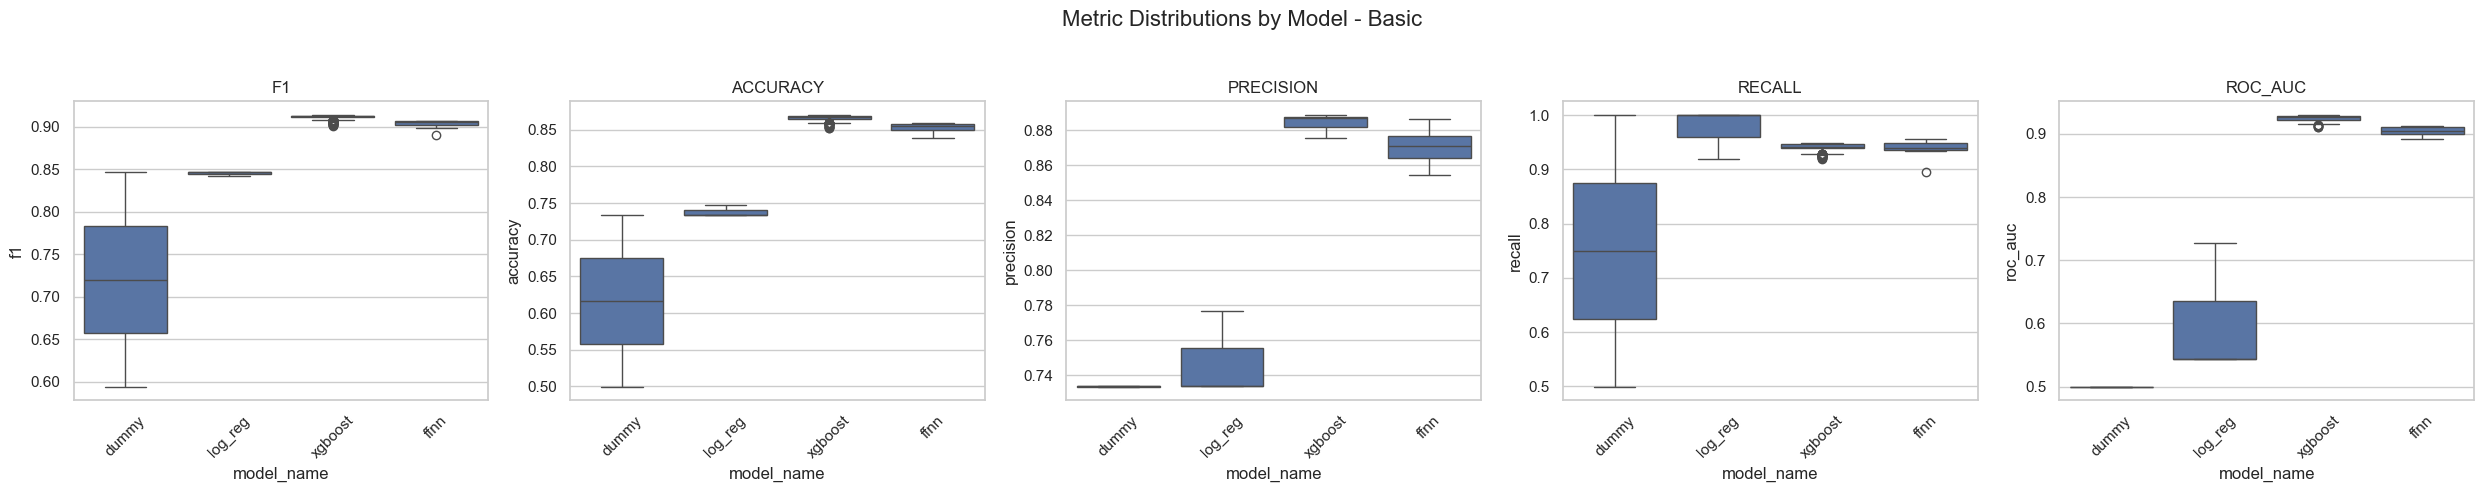

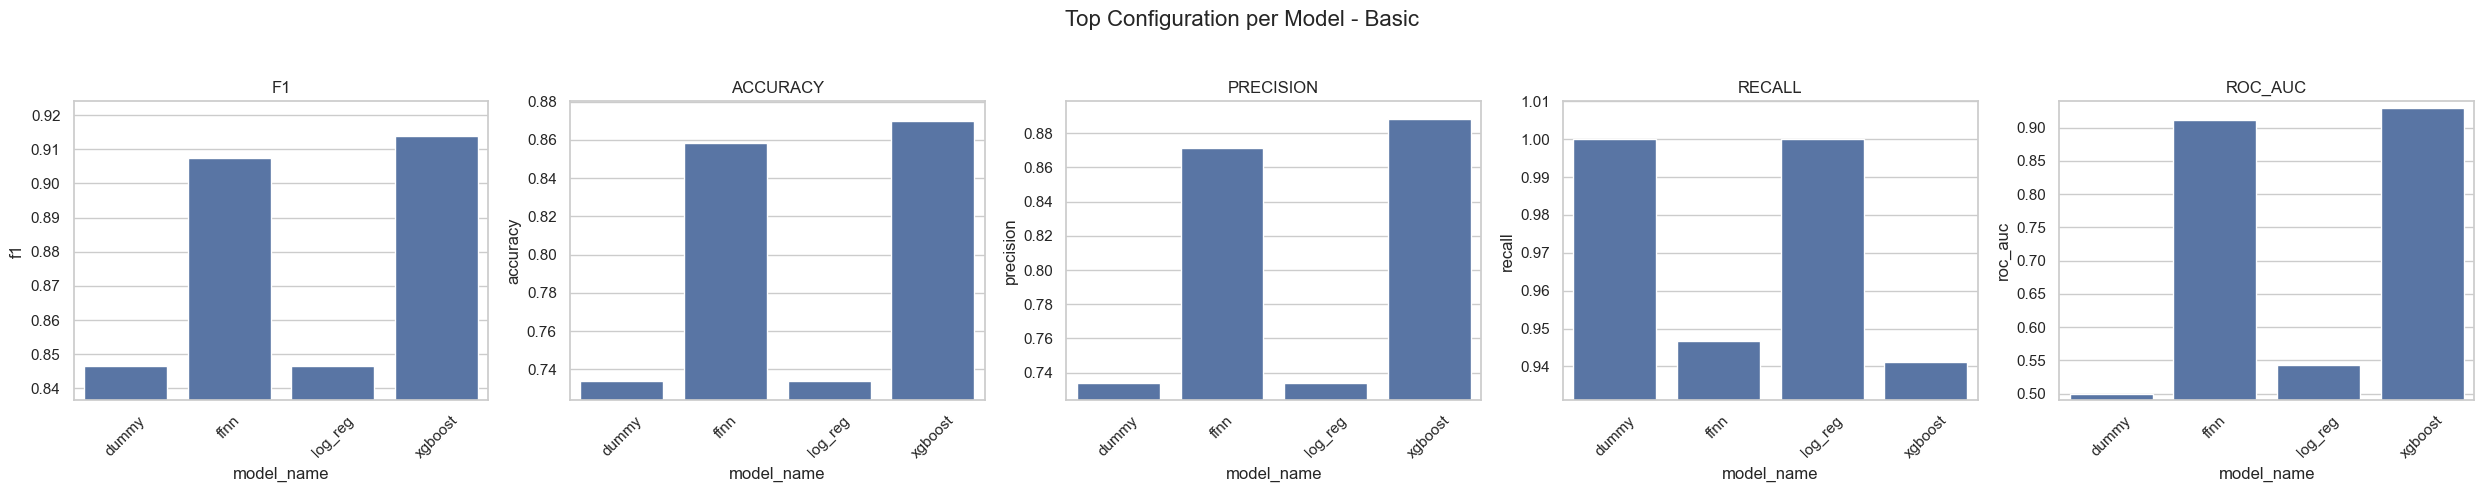

v6


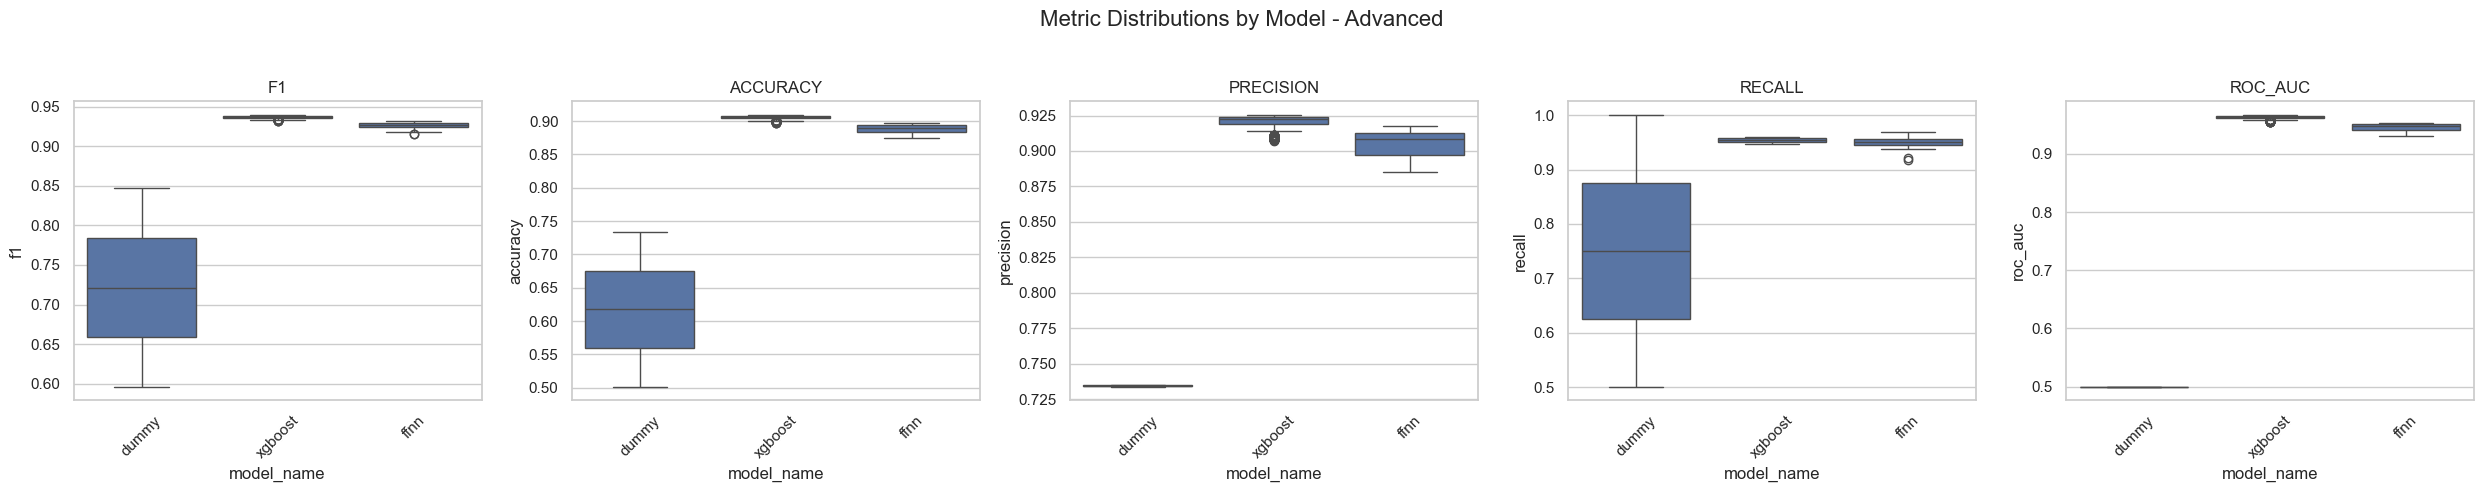

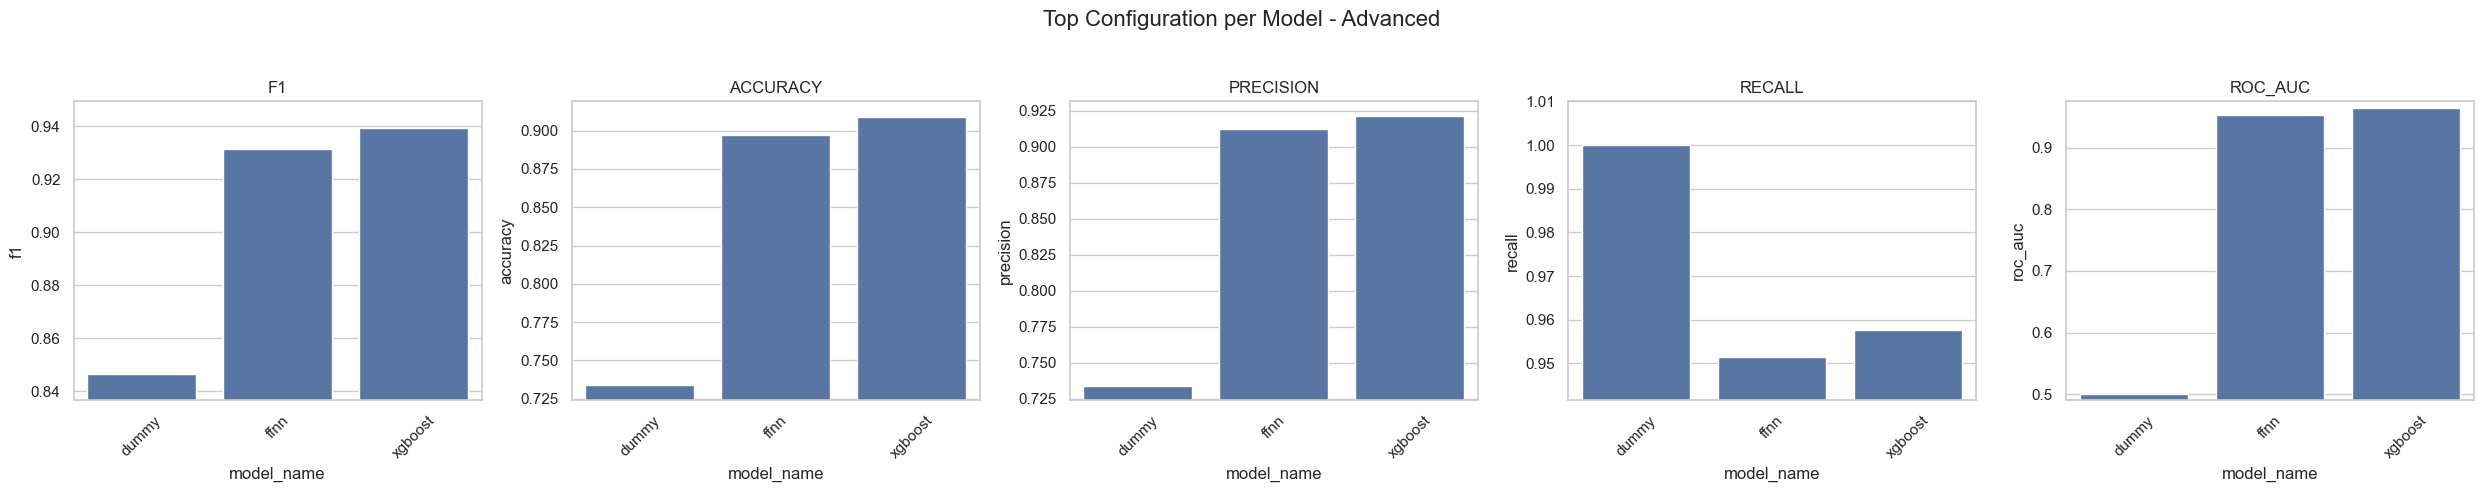

pass


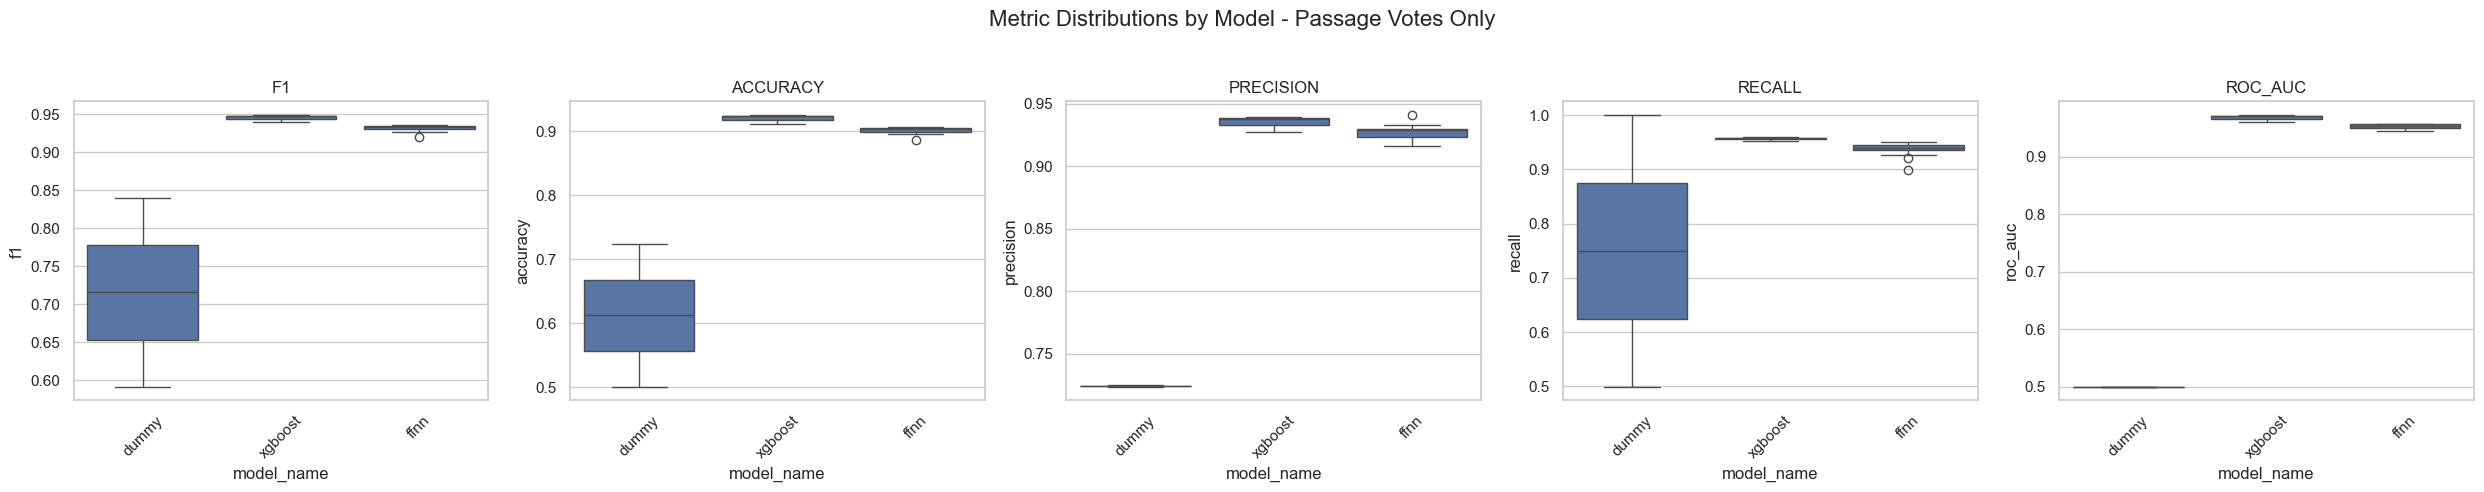

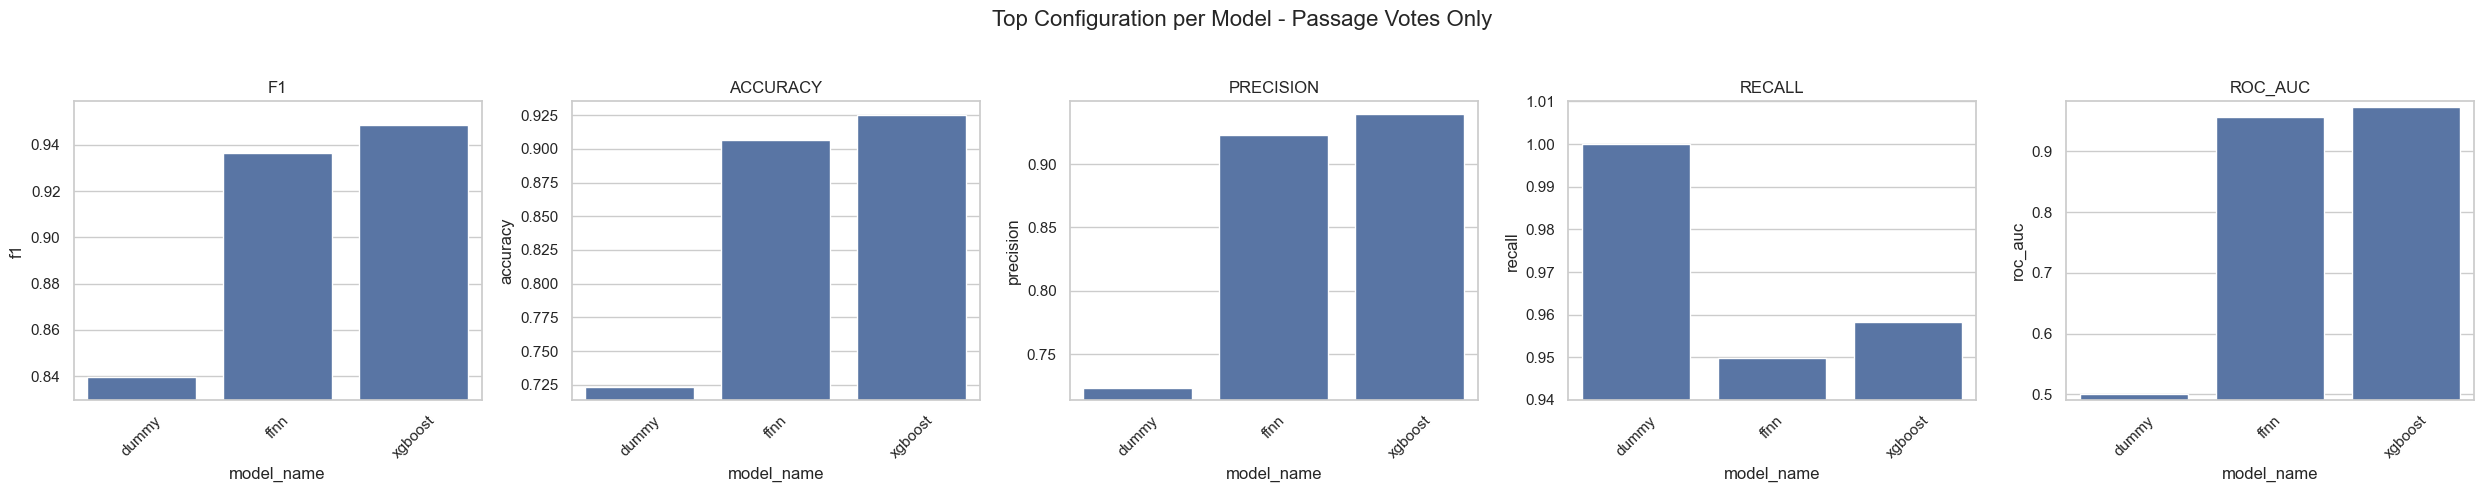

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df['dataset'] = df['model_id'].apply(lambda x: x.split('_')[0])

metrics = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc']
datasets = df['dataset'].unique()
sns.set(style="whitegrid")

for dataset in datasets:
    df_subset = df[df['dataset'] == dataset]
    print(dataset)
    dataset = {
        Datasets.V3.value: "Basic",
        Datasets.V6.value: "Advanced",
        "pass": "Passage Votes Only",
    }[dataset]
    
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns
    fig.suptitle(f"Metric Distributions by Model - {dataset}", fontsize=16)
    axs = axs.flatten()  # Flatten to index like a list
    for i, metric in enumerate(metrics):
        sns.boxplot(data=df_subset, x='model_name', y=metric, ax=axs[i])
        axs[i].set_title(metric.upper())
        axs[i].tick_params(axis='x', rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    top_per_model = (
        df_subset.sort_values(by=metrics, ascending=False)
        .groupby('model_name', as_index=False)
        .first()
    )

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns
    axs = axs.flatten()  # Flatten to index like a list
    fig.suptitle(f"Top Configuration per Model - {dataset}", fontsize=16)
    for i, metric in enumerate(metrics):
        sns.barplot(data=top_per_model, x='model_name', y=metric, ax=axs[i])
        axs[i].set_title(metric.upper())
        axs[i].tick_params(axis='x', rotation=45)

        vals = top_per_model[metric]
        ymin = vals.min() - 0.01
        ymax = vals.max() + 0.01
        axs[i].set_ylim(ymin, ymax)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

/var/folders/y7/rdkd1_7d3b9fjykc4g2vvjl00000gn/T/ipykernel_33709/862366851.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.92])


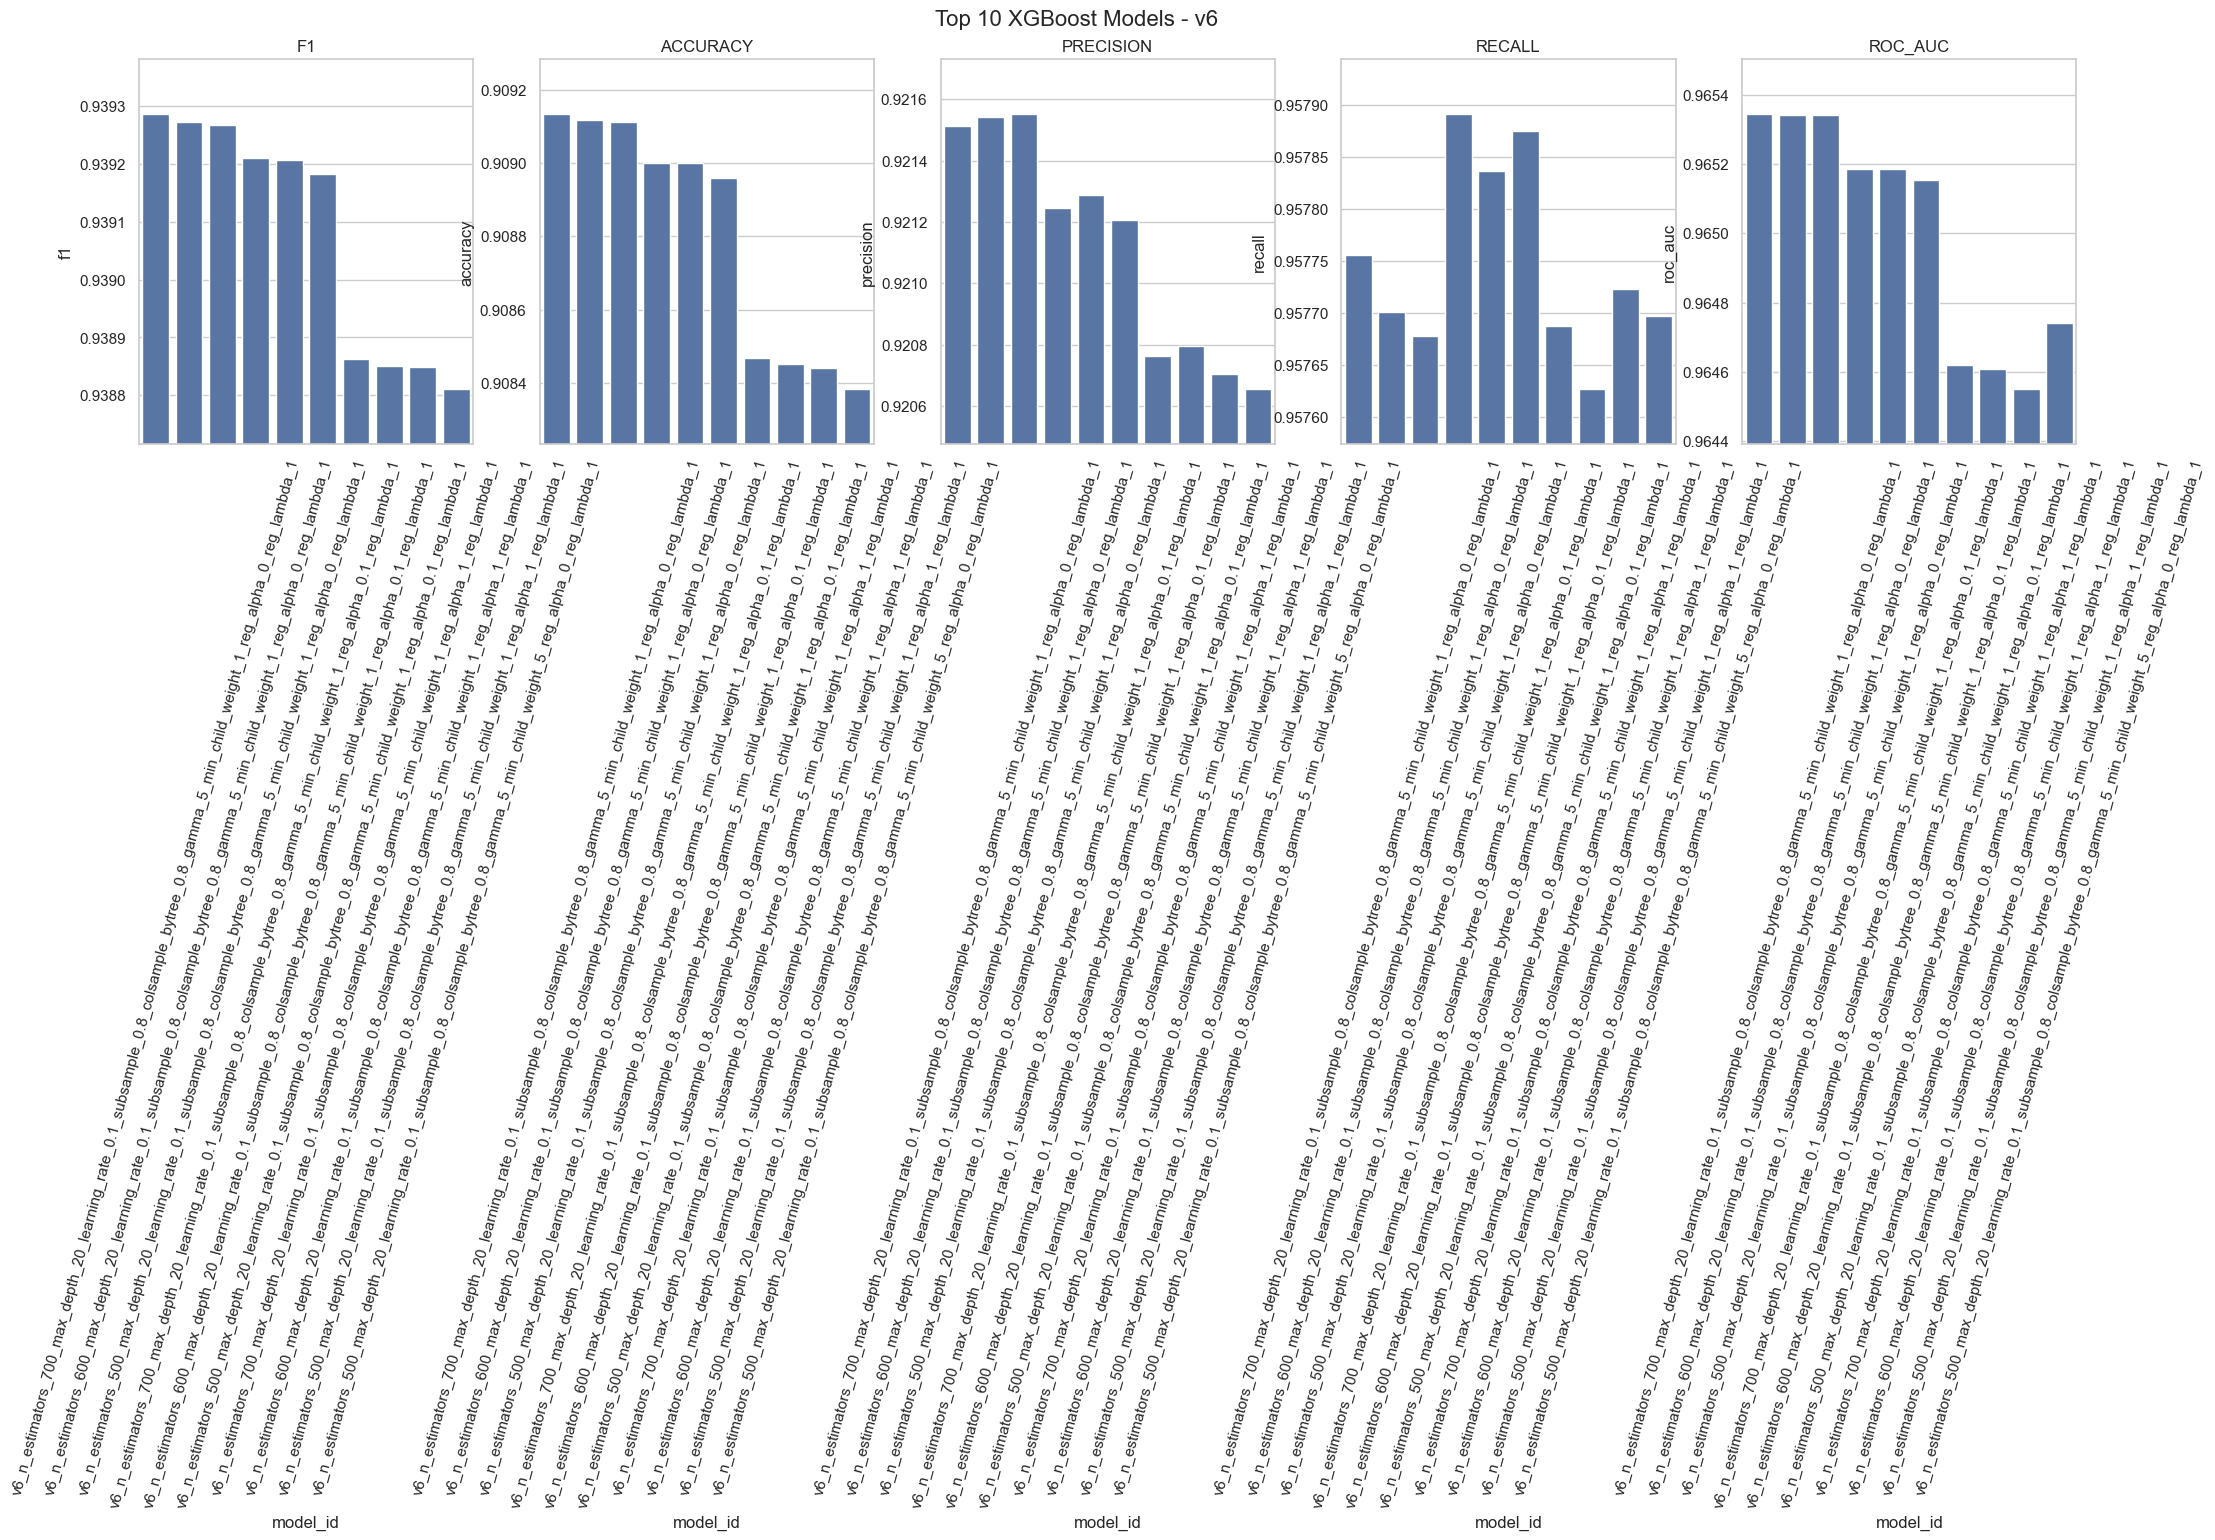

/var/folders/y7/rdkd1_7d3b9fjykc4g2vvjl00000gn/T/ipykernel_33709/862366851.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.92])


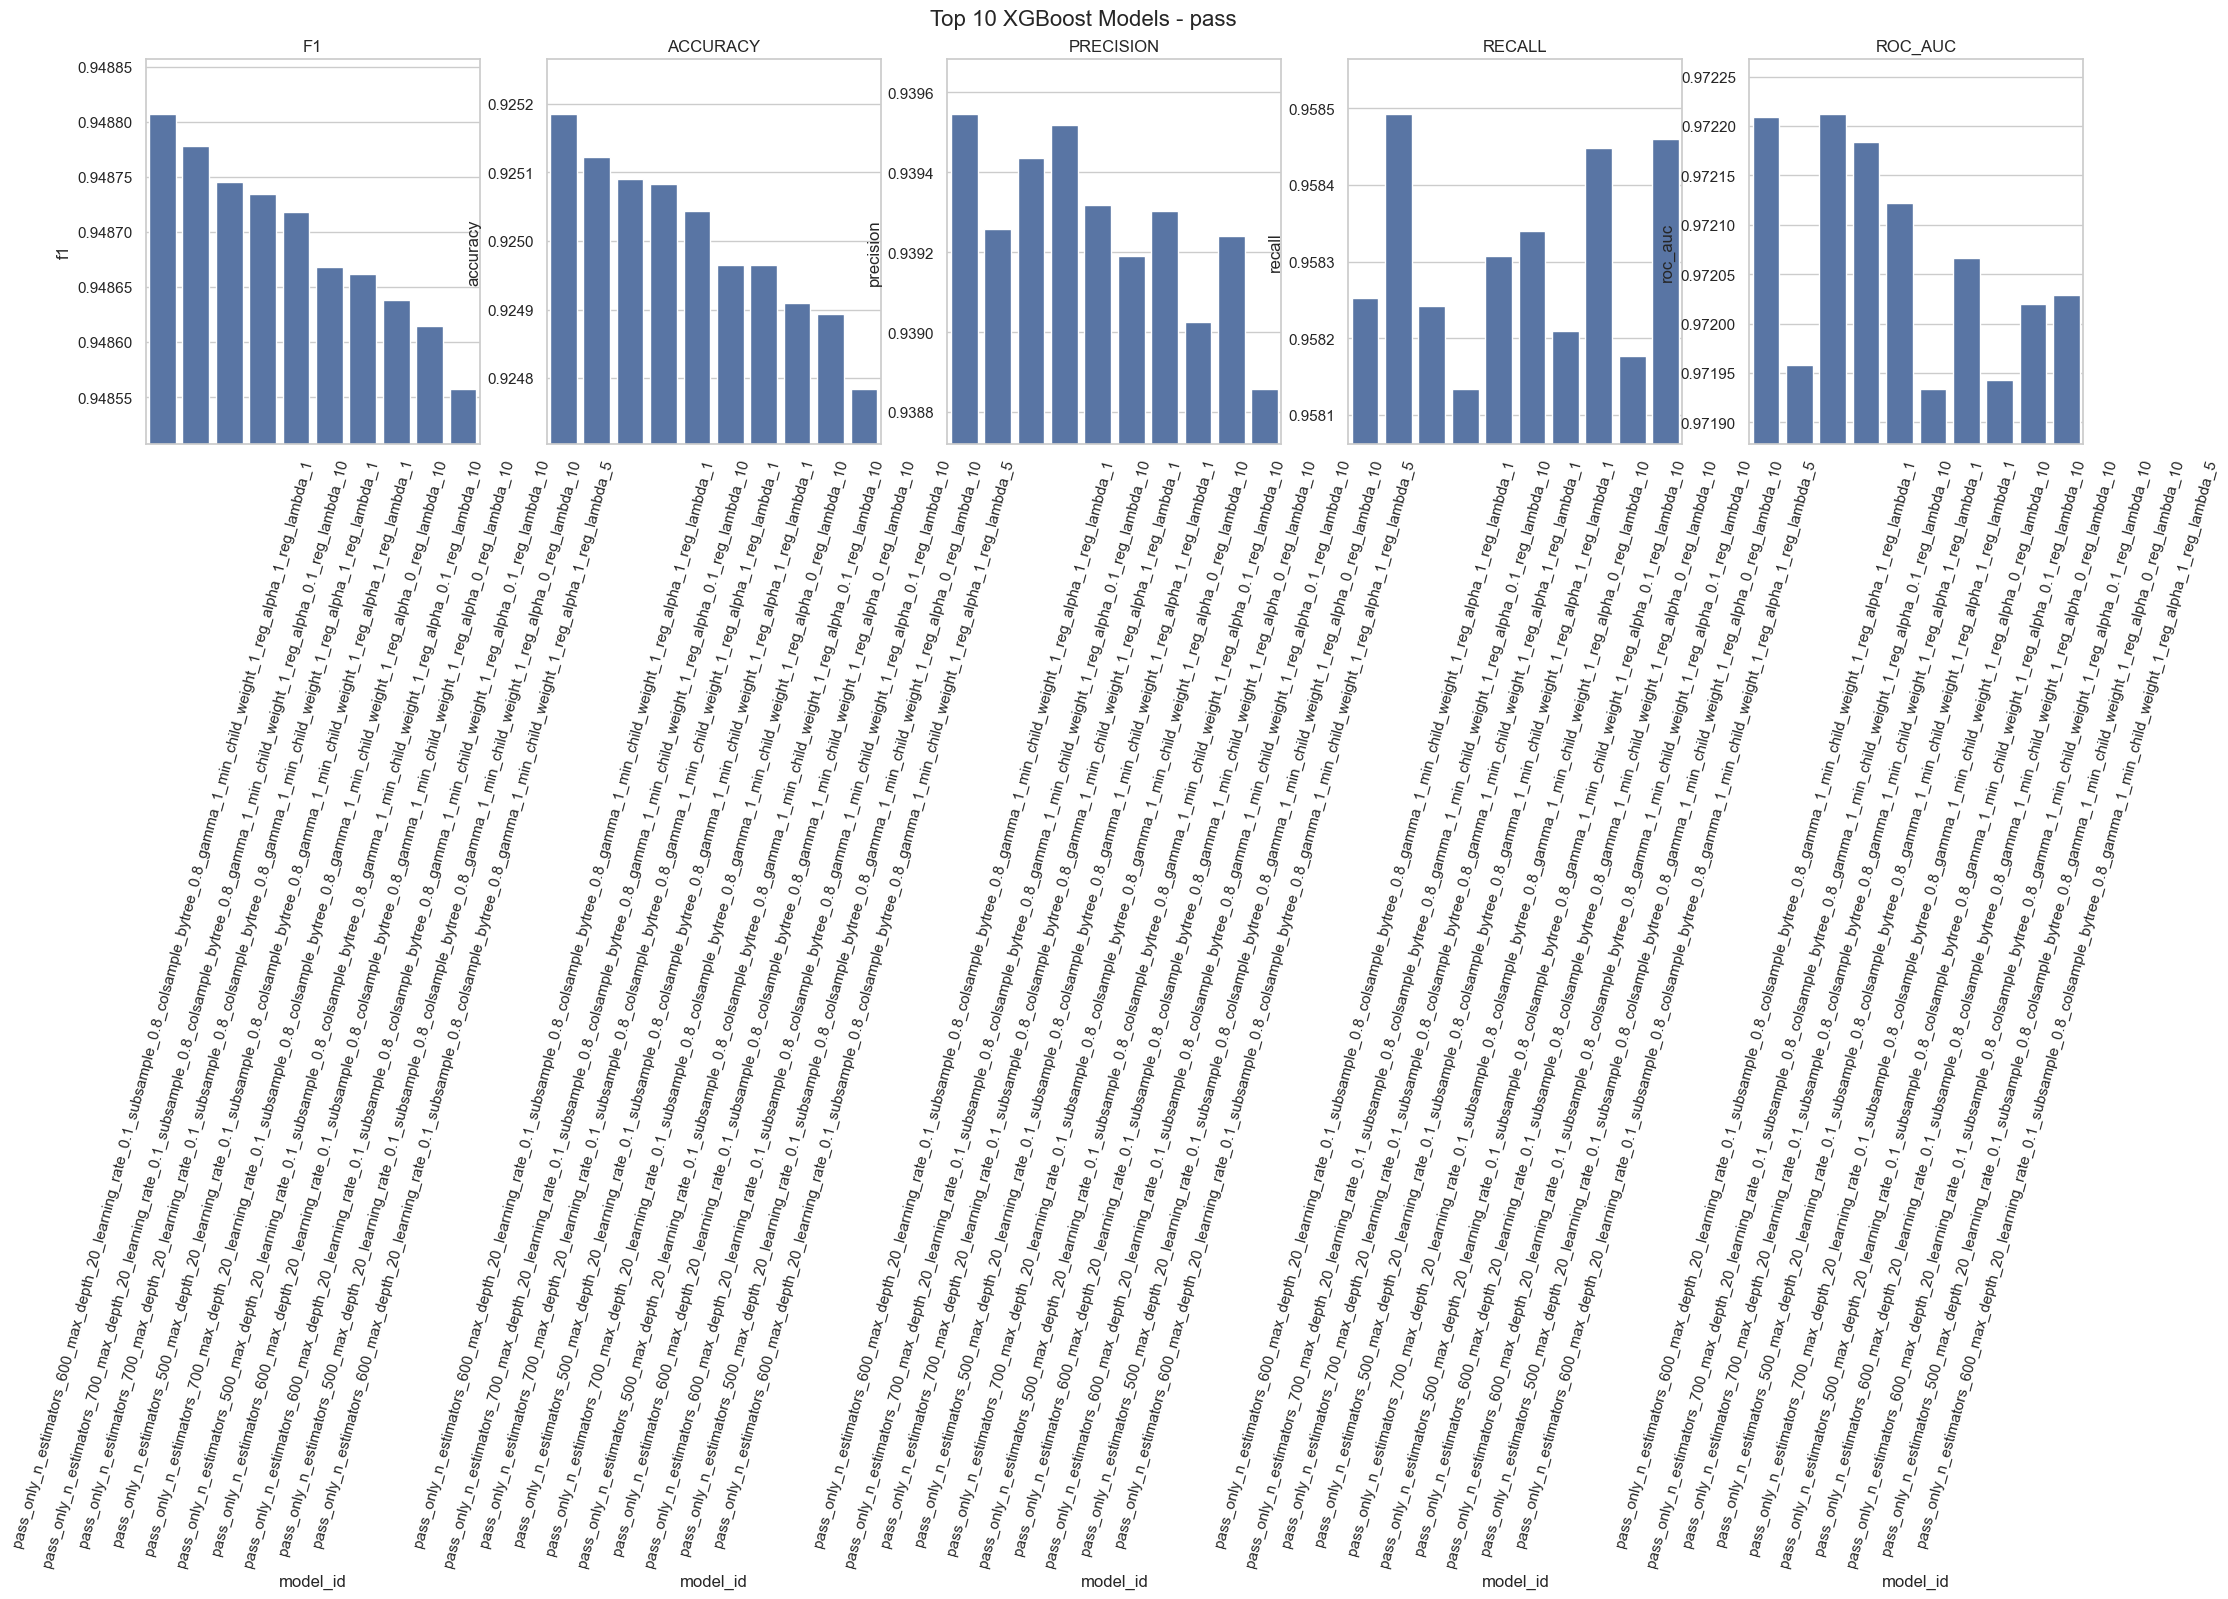

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df['dataset'] = df['model_id'].apply(lambda x: x.split('_')[0])

xgb_df = df[df['model_name'].str.lower() == 'xgboost'].copy()

metrics = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc']

def plot_grouped_xgb_top10(dataset_name):
    top10 = xgb_df[xgb_df['dataset'] == dataset_name].sort_values(by='f1', ascending=False).head(10)

    fig, axs = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5), sharex=False)
    fig.suptitle(f'Top 10 XGBoost Models - {dataset_name}', fontsize=16)

    for i, metric in enumerate(metrics):
        sns.barplot(data=top10, x='model_id', y=metric, ax=axs[i])
        axs[i].set_title(metric.upper())
        axs[i].tick_params(axis='x', rotation=75)
        
        # Scaled y-axis
        min_val = top10[metric].min()
        max_val = top10[metric].max()
        delta = max_val - min_val
        padding = delta * 0.2 if delta > 0 else 0.01
        axs[i].set_ylim(min_val - padding, max_val + padding)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

plot_grouped_xgb_top10("v6")
plot_grouped_xgb_top10("pass")

/Users/declannelson/Desktop/columbia/stat5241/stat5241_team_7/env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



#### Test Set Performance for XGBoost V6 ####
accuracy: 0.9091
precision: 0.9215
recall: 0.9577
f1: 0.9392
roc_auc: 0.9657


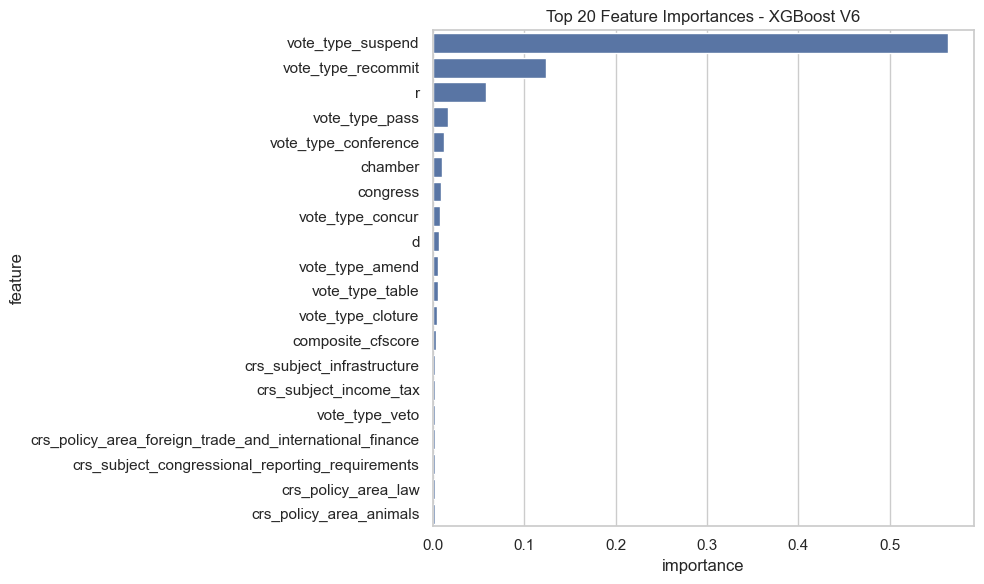

/Users/declannelson/Desktop/columbia/stat5241/stat5241_team_7/env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [18:31:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



#### Test Set Performance for XGBoost Pass Only ####
accuracy: 0.9247
precision: 0.9388
recall: 0.9584
f1: 0.9485
roc_auc: 0.9723


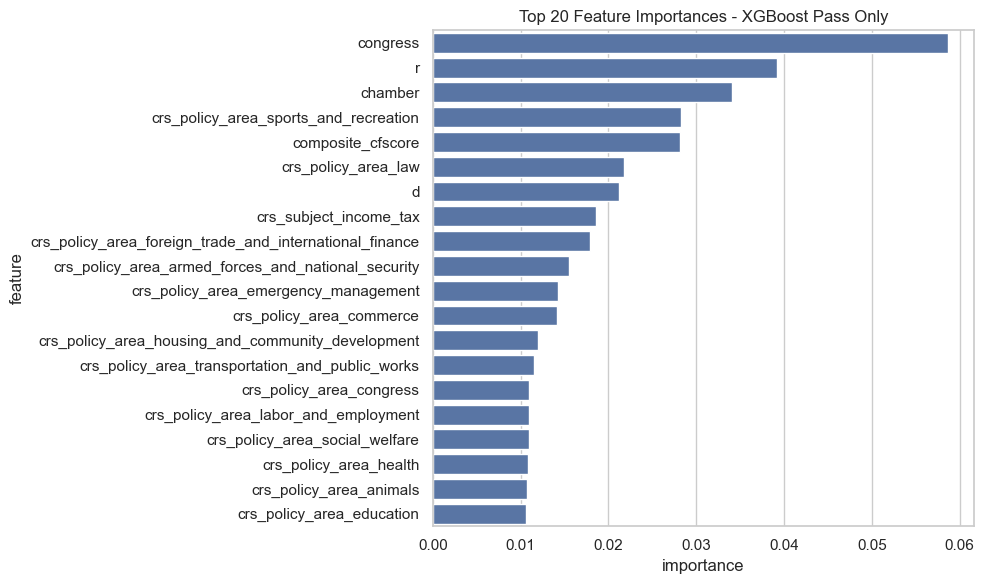

In [14]:


v6_params = {
    "n_estimators": 700, "max_depth": 20, "learning_rate": 0.1,
    "subsample": 0.8, "colsample_bytree": 0.8, "gamma": 5,
    "min_child_weight": 1, "reg_alpha": 0, "reg_lambda": 1, "n_jobs": -1
}

pass_params = {
    "n_estimators": 600, "max_depth": 20, "learning_rate": 0.1,
    "subsample": 0.8, "colsample_bytree": 0.8, "gamma": 1,
    "min_child_weight": 1, "reg_alpha": 1, "reg_lambda": 1, "n_jobs": -1
}

v6_model = XGBoostModel(dataset=Datasets.V6, kwargs_for_model=v6_params, verbose=True)
pass_model = XGBoostModel(dataset=Datasets.PASS_ONLY, kwargs_for_model=pass_params, verbose=True)

def plot_importance(model, feature_names, title, top_n=20):
    importances = model.feature_importances_
    feat_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feat_df = feat_df.sort_values(by='importance', ascending=False).head(top_n)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feat_df, x='importance', y='feature')
    plt.title(f'Top {top_n} Feature Importances - {title}')
    plt.tight_layout()
    plt.show()

def run_and_evaluate(model_obj: XGBoostModel, label: str):
    target, features, df = model_obj.dataset.get_dataset()
    train_df, val_df, test_df = split_data(
        df, target_col=target
    )

    model = model_obj.train(train_df[features], train_df[target])
    y_pred, y_prob = model_obj.predict(model, test_df[features])
    
    from src.models.evaluation import evaluate_predictions
    metrics = evaluate_predictions(test_df[target], y_pred, y_prob)
    print(f"\n#### Test Set Performance for {label} ####")
    for k, v in metrics.items():
        if k != "confusion_matrix":
            print(f"{k}: {v:.4f}")
    
    plot_importance(model, features, label)
    return metrics

v6_test_metrics = run_and_evaluate(v6_model, "XGBoost V6")
pass_test_metrics = run_and_evaluate(pass_model, "XGBoost Pass Only")

In [68]:
response, v3_features, df = Datasets.V3.get_dataset()
v3_features[-1]

'crs_policy_area_water_resources_development'

Text(0.5, 1.0, 'Top 10 CRS Policy Areas')

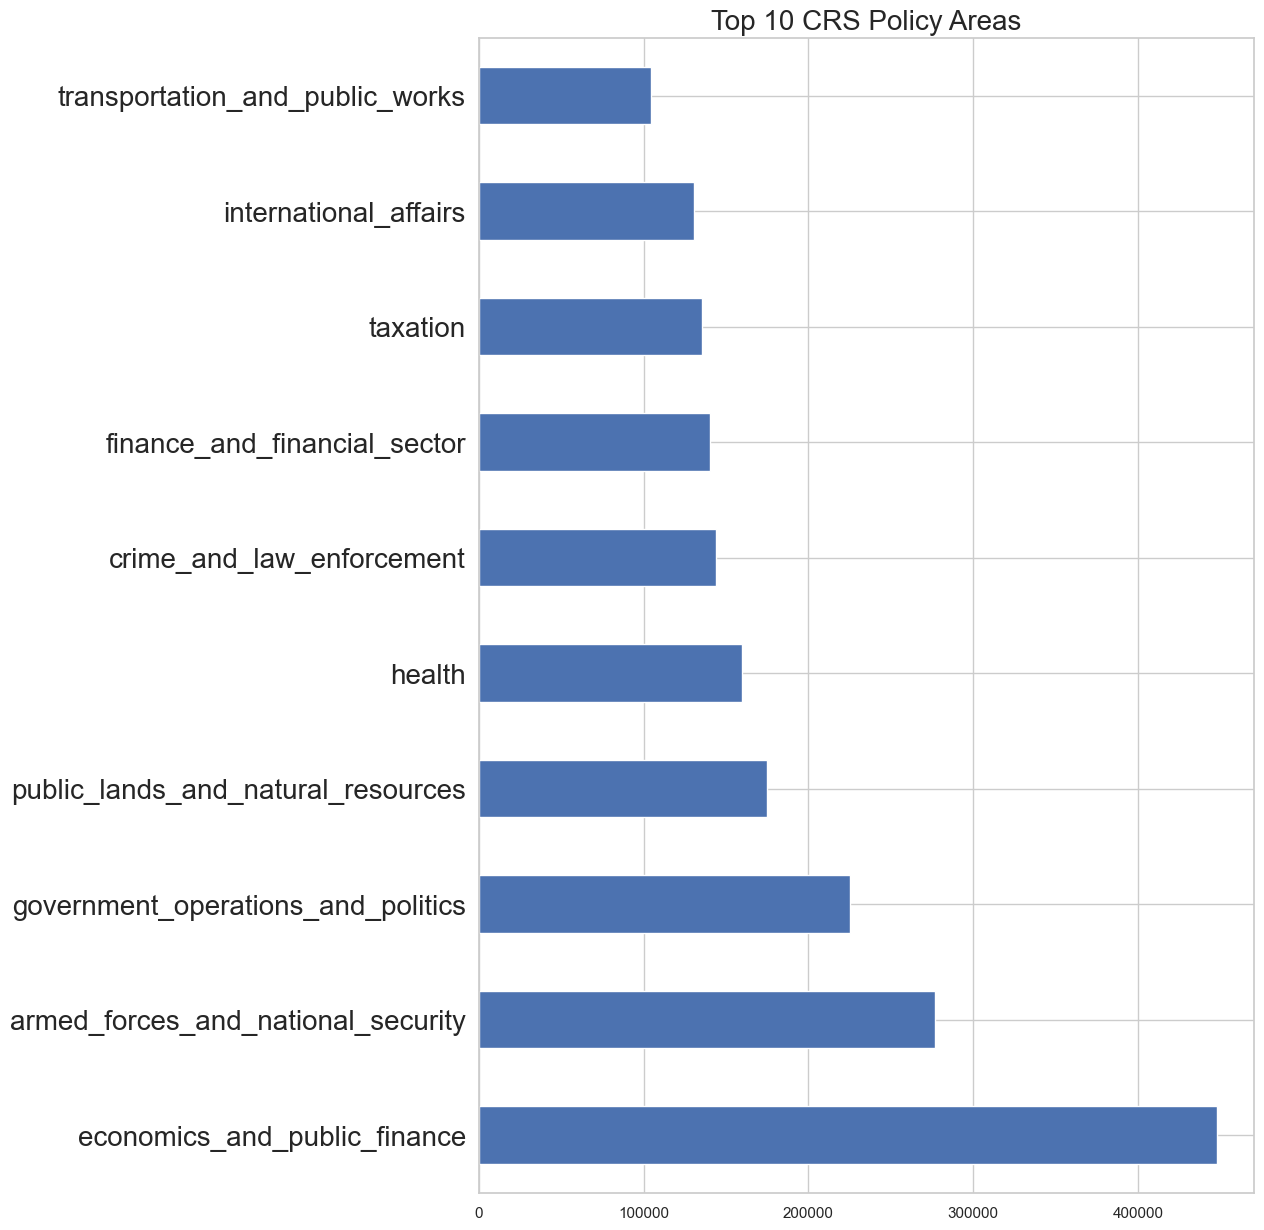

In [70]:
c_df = df[[c for c in df.columns if c.startswith("crs_") and "other" not in c]]
ax = c_df.rename(columns={c: c.replace('crs_policy_area_', '') for c in c_df}).sum().sort_values(ascending=False).dropna().head(10).plot.barh(figsize=(10, 15))
ax.tick_params(axis='y', labelsize=20)
ax.set_title("Top 10 CRS Policy Areas", fontsize=20)

(2823025, 116)
['state_icpsr', 'district_code', 'personal_cfscore', 'contributor_cfscore', 'composite_cfscore', 'num_contributors', 'num_contributions', 'ind_contributions', 'pac_contributions', 'party_contributions', 'amount_spent', 'primary_election_pct', 'general_election_pct', 'gender', 'crs_subject_congressional_reporting_requirements', 'crs_subject_congressional_oversight', 'crs_subject_government_trust_funds', 'crs_subject_higher_education', 'crs_subject_administrative_procedure', 'crs_subject_government_paperwork', 'crs_subject_appropriations', 'crs_subject_federal_advisory_bodies', 'crs_subject_federal_employees', 'crs_subject_small_business', 'crs_subject_elementary_and_secondary_education', 'crs_subject_minorities', 'crs_subject_research_and_development', 'crs_subject_drug_abuse', 'crs_subject_executive_reorganization', 'crs_subject_fines_(penalties)', 'crs_subject_california', 'crs_subject_licenses', 'crs_subject_terrorism', 'crs_subject_disabled', 'crs_subject_government_p

Text(0.5, 1.0, 'Top 10 CRS Subject Areas')

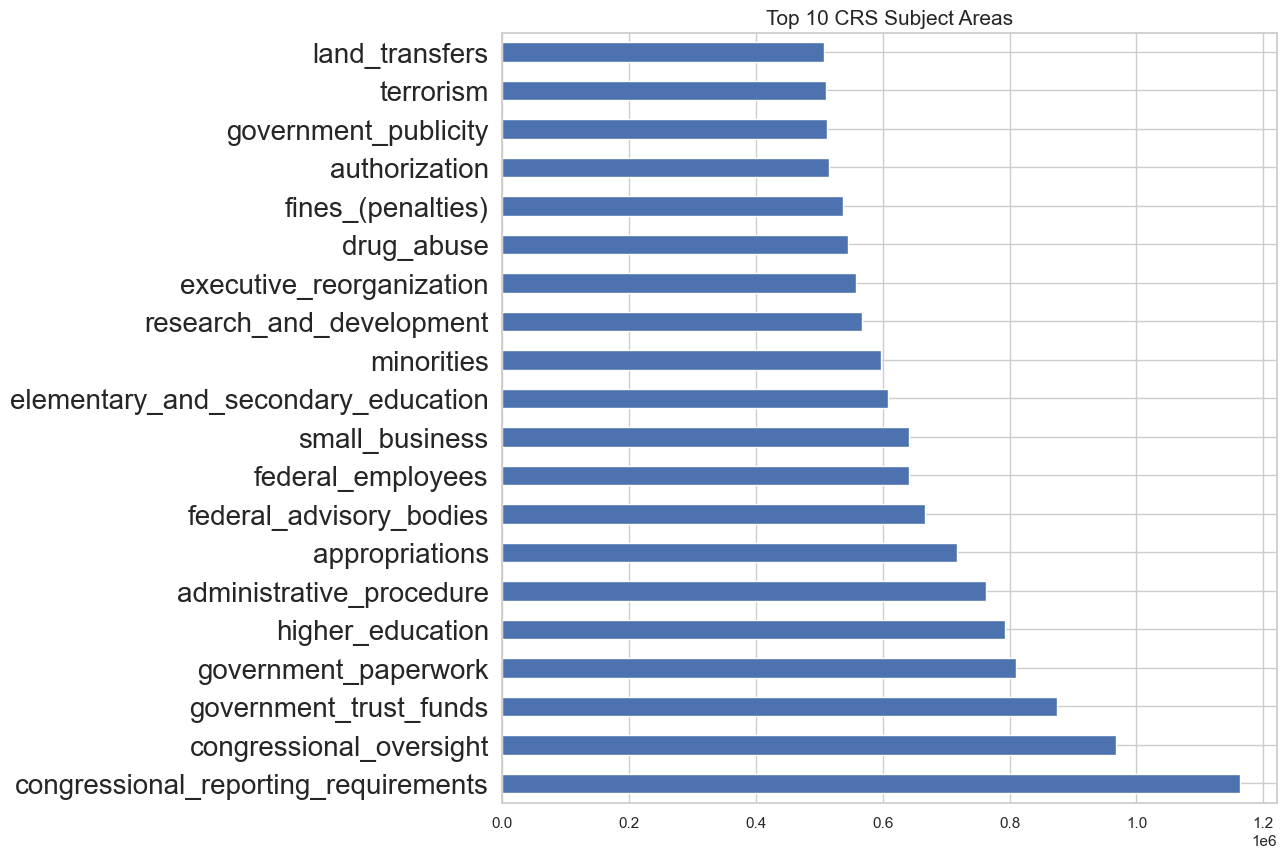

In [85]:
response, features, df = Datasets.V6.get_dataset()
print(df.shape)
print([f for f in features if f not in v3_features])
ax = df[[f for f in features if f.startswith('crs_subject_') and "other" not in f]].rename(columns={c: c.replace("crs_subject_", "") for c in features}).sum().sort_values(ascending=False).head(20).plot.barh(figsize=(10, 10))
ax.tick_params(axis='y', labelsize=20)
ax.set_title("Top 10 CRS Subject Areas", fontsize=15)


<Axes: title={'center': 'Vote Type'}>

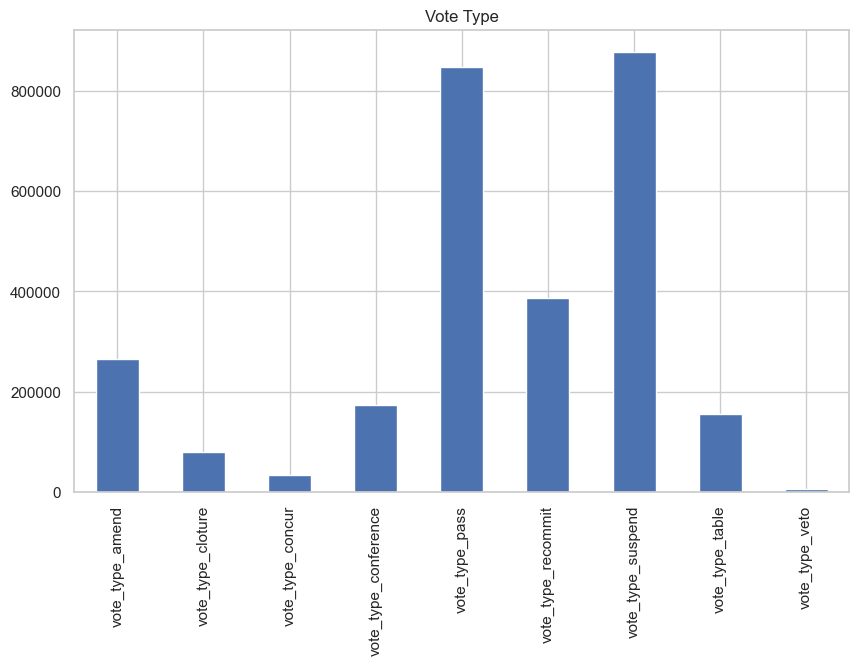

In [91]:
df[[f for f in features if "vote_type" in f]].sum().plot.bar(title="Vote Type", figsize=(10, 6))